In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt

In [ ]:
# read data
df = pd.read_csv('/content/drive/MyDrive/University of Padova/11. Network Science/data/final_dataset.csv')
df = df[['yr','rt3ISO','pt3ISO','cmdCode','TradeValue']]
# Select specific year and commodity
df = df[(df.yr == 2015)&(df.cmdCode==1)]

In [ ]:
countries = list(np.intersect1d(df.rt3ISO.unique(),df.pt3ISO.unique()))

# Drop those that appear as partners but not as reporters
df = df[df.pt3ISO.isin(countries) & df.rt3ISO.isin(countries)]

In [ ]:
non_zero = []

# initialize adjacency matrix
adj = np.zeros((len(countries),len(countries)))
# Don't iterate over df, it's extremely inefficient
for index, entry in df.iterrows():
    reporter = countries.index(entry.rt3ISO) 
    partner = countries.index(entry.pt3ISO)
    # The rows are the imports, the columns are the exports
    # No self-loops: zero diagonal
    adj[reporter,partner] = entry.TradeValue
    # append edge
    non_zero.append((reporter,partner))


In [ ]:
adj = np.random.random((100,100))*np.random.choice([0,0,0,1],(100,100))
non_zero = []
for i in range(100):
  for j in range(100):
    if adj[i,j] > 0: non_zero.append((i,j))

In [ ]:
# How much does country i import?
imports = adj.sum(axis = 1) # summation or row elements
# How much does country j export?
exports = adj.sum(axis = 0) # summation of column elements
print(np.all(imports>0))

True


In [ ]:
# Attack
step = 10
N = 5000
imp_red_avg = []
imp_red_dev = []
exp_red_avg = []
exp_red_dev = []

# Remove an increasing number of edges
for i in range(1,int(len(non_zero)/2),step):
    imp_reds = []
    exp_reds = []
    # repeat many times to get an appropriate average
    for j in range(N):
        attacks = rd.sample(non_zero,i)
        rows = np.array([a[0] for a in attacks])
        cols = np.array([a[1] for a in attacks])
        # Perform attack
        _adj = np.copy(adj)
        _adj[rows,cols] = 0
        n_imports = _adj.sum(axis = 1)
        n_exports = _adj.sum(axis = 0)
        # What percentage of exports/imports remains?
        res_imports = n_imports/imports
        res_exports = n_exports/exports
        # What's the average impact?
        imp_impact = 1 - res_imports[np.unique(rows)]# Only considering the impact over affected countries
        exp_impact = 1 - res_exports[np.unique(cols)]
        imp_reds.append(np.average(imp_impact))
        exp_reds.append(np.average(exp_impact))

    # What is the "average average" impact?
    imp_red_avg.append(np.average(imp_reds))
    exp_red_avg.append(np.average(exp_reds))
    # What is the standar deviation of the average impact?
    imp_red_dev.append(np.std(imp_reds))
    exp_red_dev.append(np.std(exp_reds))

In [ ]:
removed = [i for i in range(1,int(len(non_zero)/2),step)]
len(removed)

125

<ErrorbarContainer object of 3 artists>

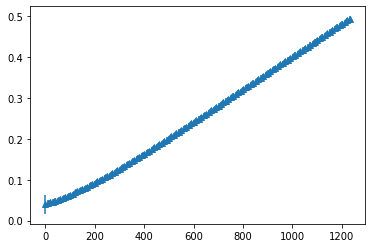

In [ ]:
# Plot
ran = -1
plt.errorbar(removed[:ran], imp_red_avg[:ran], imp_red_dev[:ran], linestyle='None', marker='^')

In [6]:
#### MULTI LAYER COMMUNITY DETECTION ALGORITHMS
import pandas as pd
import numpy as np
import random as rd
from functools import reduce
import matplotlib.pyplot as plt

In [156]:
# We model multilayers as adjacency matrices
# read data
df = pd.read_csv('/content/drive/MyDrive/University of Padova/11. Network Science/data/final_dataset.csv')
df = df[['yr','rt3ISO','pt3ISO','cmdCode','TradeValue']]
# Select specific year
df = df[(df.yr == 2015)]
# Get list of countries
countries = list(np.intersect1d(df.rt3ISO.unique(),df.pt3ISO.unique()))
# Get list of commodities
commodities = list(df.cmdCode.unique())
# Drop those that appear as partners but not as reporters
df = df[df.pt3ISO.isin(countries) & df.rt3ISO.isin(countries)]
# Drop those entries which report a 0 tradevalue
df = df[df.TradeValue > 0]

# indexize the importer, exporter and comodity
df['rt'] = df.rt3ISO.apply(lambda x: countries.index(x))
df['pt'] = df.pt3ISO.apply(lambda x: countries.index(x))
df['cm'] = df.cmdCode.apply(lambda x: commodities.index(x))

# Build multilayer array

m_adj = np.zeros((len(countries),len(countries),len(commodities)))

m_adj[df.rt,df.pt,df.cm] = df.TradeValue

# Layer normalization
for layer in range(len(commodities)):
  m_adj[:,:,layer] = m_adj[:,:,layer]/m_adj[:,:,layer].sum()

In [11]:
def neighbours(adj_mat,index,_in = True):
  indexer = np.arange(adj_mat.shape[0])
  if _in:
    mask = (adj_mat[index,:] != 0)
  else:
    mask = (adj_mat[:,index] != 0)
  return indexer[mask]

def N_ij(i,j,adj):
  neigh_i = neighbours(adj,i)
  neigh_j = neighbours(adj,j,_in = False)
  return np.intersect1d(neigh_i,neigh_j)

def U_ij(i,j,adj):
  neigh_i = neighbours(adj,i)
  neigh_j = neighbours(adj,j,_in = False)
  return np.union1d(neigh_i,neigh_j)

def com_sim(community_1,community_2):
  inter = np.intersect1d(community_1,community_2)
  union = np.union1d(community_1,community_2)
  return len(inter)/len(union)

def total_neighbours(ml_adj_mat,index_i,_in = True):
  layers = [i for i in range(ml_adj_mat.shape[2])]
  _neighbours = [neighbours(m_adj[:,:,l],index_i,_in) for l in layers]
  return reduce(np.union1d,_neighbours)

a = np.array([
              [0,1,0],
              [1,0,1],
              [0,0,0]
              ])
# Define tests
neighbours(a,2,_in = False)


array([1])

In [131]:
### similarity measures
def jaccard(ml_adj_mat,i,j):
  dummy = 0
  part = 0
  for layer in range(ml_adj_mat.shape[2]):
    adj_layer = ml_adj_mat[:,:,layer]
    N = N_ij(i,j,adj_layer)
    _N = N_ij(j,i,adj_layer)
    U = U_ij(i,j,adj_layer)
    _U = U_ij(j,i,adj_layer)
    w = 1#adj_layer.sum()
    # TODO: review this issue
    # Guess it only arises when we're comparing not-neighbour nodes
    # which country does not import a given commodity?
    if len(U) == 0 or len(_U) == 0:
      #print(layer)
      return 0
    dummy += (len(N)/len(U) + len(_N)/len(_U))/(2*w)
    part += w

  return dummy/part


In [157]:
jacc_sims = {}
all_neighbours = {}
for i in range(len(countries)):
  all_neighbours[i] = total_neighbours(m_adj,i)
  for j in all_neighbours[i]:
    sim = jaccard(m_adj,i,j)
    jacc_sims[(i,j)] = sim


In [167]:
thres_neigh = np.average(list(jacc_sims.values()))

In [168]:
filtered_neighbours = [[] for i in range(len(countries))]
for node in range(len(countries)):
  for j in all_neighbours[node]:
    if jacc_sims[(node,j)] <= thres_neigh: continue
    filtered_neighbours[node].append(j)

In [169]:
labels = np.arange(len(countries))

In [161]:
def mnlpa(labels,filtered_neighbours,ml_adj_mat):
  for _ in range(10):
    guide = np.arange(len(labels))
    np.random.shuffle(guide)
    for node in guide:
      # The score of a label results from
      # adding all the weights for the edges
      # between target node and nodes 
      # for which this label was assigned
      f_neigh = filtered_neighbours[node]
      if not f_neigh: continue
      scores = {l: 0 for l in labels[f_neigh]}
      for neigh in f_neigh:
        label = labels[neigh]
        scores[label] += ml_adj_mat[node,neigh,:].sum()
      chosen = max(labels[f_neigh],key = lambda label: scores[label])
      labels[node] = chosen

In [170]:
mnlpa(labels,filtered_neighbours,m_adj)

In [171]:
np.unique(labels).shape

(62,)

In [172]:
np.array(countries)[np.unique(labels)]

array(['ABW', 'AFG', 'AGO', 'AND', 'ATG', 'AUS', 'BDI', 'BEN', 'BFA',
       'BHS', 'BLZ', 'BMU', 'BRA', 'BRB', 'BRN', 'BWA', 'CAF', 'CAN',
       'COD', 'COG', 'COM', 'CPV', 'CYM', 'DZA', 'FJI', 'GIN', 'GMB',
       'GRD', 'GRL', 'GUY', 'JAM', 'KGZ', 'KHM', 'KIR', 'KNA', 'LCA',
       'LSO', 'MAC', 'MDV', 'MNG', 'MOZ', 'MRT', 'MWI', 'NAM', 'NCL',
       'NER', 'NLD', 'PLW', 'PSE', 'RWA', 'SDN', 'SLB', 'SLE', 'STP',
       'SUR', 'SWZ', 'TGO', 'VCT', 'WSM', 'YEM', 'ZMB', 'ZWE'],
      dtype='<U3')

In [139]:
np.array(countries)[np.unique(labels)]

array(['ARG', 'CAF', 'CAN', 'COM', 'CYM', 'DEU', 'PLW', 'STP'],
      dtype='<U3')

In [140]:
countries_data = pd.read_csv('/content/drive/MyDrive/University of Padova/11. Network Science/data/countries.csv')

In [143]:
coordinates = {d.cc3: (d.latitude,d.longitude) for _, d in countries_data.iterrows()}
coordinates

{'ABW': (12.52111, -69.968338),
 'AFG': (33.93911, 67.709953),
 'AGO': (-11.202692, 17.873887),
 'AIA': (18.220554, -63.068615),
 'ALA': (60.1995487, 20.3711715),
 'ALB': (41.153332, 20.168331),
 'AND': (42.546245, 1.601554),
 'ARE': (23.424076, 53.847818),
 'ARG': (-38.416097, -63.616672),
 'ARM': (40.069099, 45.038189),
 'ASM': (-14.270972, -170.132217),
 'ATA': (-75.250973, -0.071389),
 'ATF': (-49.280366, 69.348557),
 'ATG': (17.060816, -61.796428),
 'AUS': (-25.274398, 133.775136),
 'AUT': (47.516231, 14.550072),
 'AZE': (40.143105, 47.576927),
 'BDI': (-3.373056, 29.918886),
 'BEL': (50.503887, 4.469936),
 'BEN': (9.30769, 2.315834),
 'BES': (12.1683718, -68.308183),
 'BFA': (12.238333, -1.561593),
 'BGD': (23.684994, 90.356331),
 'BGR': (42.733883, 25.48583),
 'BHR': (25.930414, 50.637772),
 'BHS': (25.03428, -77.39628),
 'BIH': (43.915886, 17.679076),
 'BLM': (17.9139222, -62.8338521),
 'BLR': (53.709807, 27.953389),
 'BLZ': (17.189877, -88.49765),
 'BMU': (32.321384, -64.75737

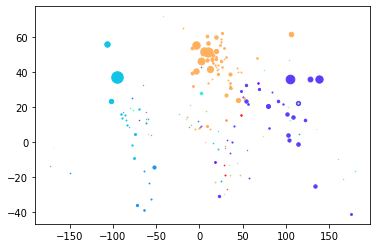

In [181]:
import matplotlib.cm as cm
lab_guide = list(np.unique(labels))
colors = cm.rainbow(np.linspace(0, 1, len(lab_guide)))

for i,country in enumerate(countries):
  lat, lon = coordinates[country]
  color = colors[lab_guide.index(labels[i])]
  size = m_adj[i,:,:].sum()
  plt.scatter(lon,lat,color = color, s = 50*size)

In [146]:
np.unique(labels,return_counts = True)

(array([  6,  29,  30,  39,  42,  45, 127, 145]),
 array([86,  1, 26,  1,  1, 52,  1,  1]))

In [195]:
# Quantify how similar two communities are
def com_sim(community_1,community_2):
  inter = np.intersect1d(community_1,community_2)
  union = np.union1d(community_1,community_2)
  return len(inter)/len(union)

# We want to compare communities from two different community proposals
# Expected for now as lists of lists, may be updated to dictionaries for labels
s = list(np.arange(12))
communities_a = [rd.sample(s,4) for _ in range(6)]
communities_b = [rd.sample(s,3) for _ in range(8)]
# We define the color palette from combined communities;
# we expect to have a color surplus
#colors = cm.rainbow(np.linspace(0, 1, len(max_com)))
ext_labels = np.arange(len(communities_b)+len(communities_a))
# ? What if they're the same size?
# now rank communities
# rows are communities in a, columns are communities in b
ranks = np.array([[com_sim(a,b) \
                   for b in communities_b]\
                   for a in communities_a])

def assign_colors(labels_a,labels_b,ranks,thre_rank):
  # We're trying to transfer labels in a to labels in b
  _ranks = ranks.copy()
  row,col = np.unravel_index(np.argmax(_ranks,axis=None),_ranks.shape)
  maxi_rank = _ranks[row,col]
  # kinda inefficient to calculate the max value of a huge matrix each time
  while maxi_rank > thre_rank:
    labels_b[col] = labels_a[row]
    _ranks[row,:] = thre_rank
    _ranks[:,col] = thre_rank
    row,col = np.unravel_index(np.argmax(_ranks,axis=None),_ranks.shape)
    maxi_rank = _ranks[row,col]

labels_a = ext_labels[:len(communities_a)]
labels_b = ext_labels[-len(communities_b):]

assign_colors(labels_a,labels_b,ranks,0.2)
print(labels_b)

[ 2  1  0  9 10  3 12 13]


In [196]:
communities_b

[[0, 3, 10],
 [2, 11, 7],
 [8, 5, 1],
 [10, 3, 6],
 [11, 7, 3],
 [7, 5, 10],
 [8, 0, 5],
 [3, 7, 10]]

In [197]:
communities_a

[[9, 7, 1, 8],
 [2, 3, 6, 11],
 [1, 5, 3, 0],
 [5, 10, 11, 9],
 [6, 0, 4, 9],
 [5, 7, 9, 1]]